# Analyze ZGEMM timings - many small calls vs batching

## Test system's hardware


**CPU hardware**

```
$ lscpu
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  48
  On-line CPU(s) list:   0-47
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Silver 4214 CPU @ 2.20GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  12
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         2200.0000
    CPU min MHz:         1000.0000
    BogoMIPS:            4400.00
```

**GPU hardware**

```
$ nvaccelinfo 

CUDA Driver Version:           12020
NVRM version:                  NVIDIA UNIX x86_64 Kernel Module  535.113.01  Tue Sep 12 19:41:24 UTC 2023

Device Number:                 0
Device Name:                   NVIDIA GeForce RTX 2080 Ti
Device Revision Number:        7.5
Global Memory Size:            11546394624
Number of Multiprocessors:     68
Concurrent Copy and Execution: Yes
Total Constant Memory:         65536
Total Shared Memory per Block: 49152
Registers per Block:           65536
Warp Size:                     32
Maximum Threads per Block:     1024
Maximum Block Dimensions:      1024, 1024, 64
Maximum Grid Dimensions:       2147483647 x 65535 x 65535
Maximum Memory Pitch:          2147483647B
Texture Alignment:             512B
Clock Rate:                    1545 MHz

[4 GPUs in total]
```

## Timings CPU version

### read data

In [1]:
# for interactive plots uncomment this following line
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Openmp, N, M, Batch_size
t = np.loadtxt('times.csv')

s = list(t.shape)
s[1] += 1
t2 = np.zeros(s)
t2[:,:-1] = t
t2[:,-1] = t[:,-2]/t[:,-1]

Nomp = np.sort(np.array(list(set(t2[:,0])), dtype=int))
N = np.sort(np.array(list(set(t2[:,1])), dtype=int))
M = np.sort(np.array(list(set(t2[:,2])), dtype=int))

### plot data - loop of ZGEMMs

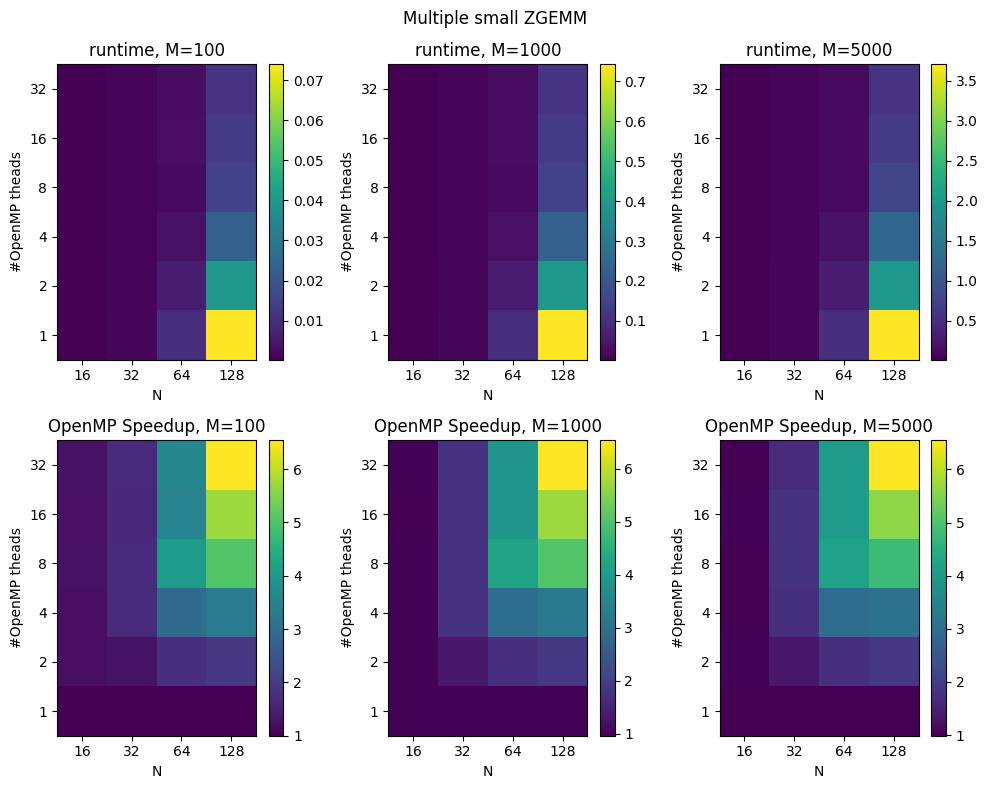

In [3]:
plt.figure(figsize=(10,8))
for i in range(3):
    plt.subplot(2,3,1+i)
    tt = t2.copy().reshape(len(Nomp), -1, 6)[:, i::3, -3]
    plt.pcolormesh(tt)
    plt.yticks(np.arange(6)+0.5, Nomp)
    plt.ylabel('#OpenMP theads')
    plt.xticks(np.arange(4)+0.5, N)
    plt.xlabel('N')
    plt.title(f'runtime, M={M[i]}')
    plt.colorbar()
    
    plt.subplot(2,3,4+i)
    tt2 = np.zeros_like(tt)
    for k in range(6):
        for l in range(4):
            tt2[k, l] = tt[0, l]/tt[k, l]
    plt.pcolormesh(tt2) #, cmap='seismic')
    # clim = plt.gci().get_clim(); clim = max(abs(clim[0]), clim[1]); plt.clim(-clim, clim)
    plt.yticks(np.arange(6)+0.5, Nomp)
    plt.ylabel('#OpenMP theads')
    plt.xticks(np.arange(4)+0.5, N)
    plt.xlabel('N')
    plt.title(f'OpenMP Speedup, M={M[i]}')
    plt.colorbar()
# plt.suptitle('Time in multiple small ZGEMM')
plt.suptitle('Multiple small ZGEMM')
plt.tight_layout()
plt.show()

### plot data - batched ZGEMMs

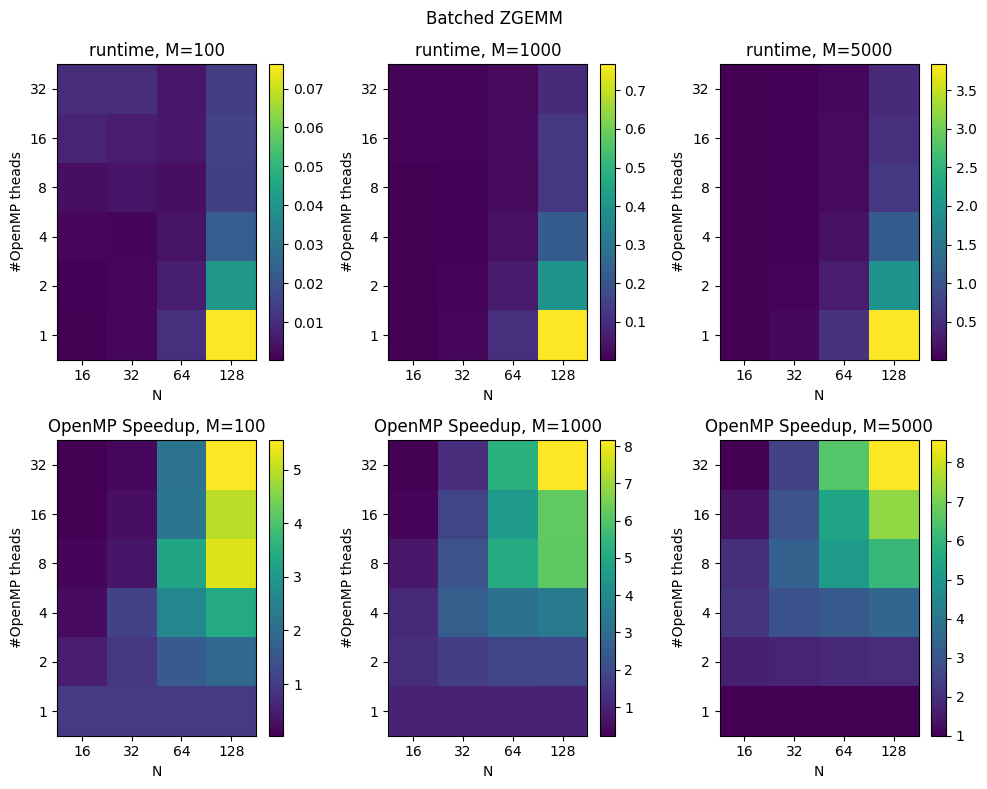

In [4]:
plt.figure(figsize=(10,8))
for i in range(3):
    plt.subplot(2,3,1+i)
    tt = t2.copy().reshape(len(Nomp), -1, 6)[:, i::3, -2]
    plt.pcolormesh(tt)
    plt.yticks(np.arange(6)+0.5, Nomp)
    plt.ylabel('#OpenMP theads')
    plt.xticks(np.arange(4)+0.5, N)
    plt.xlabel('N')
    plt.title(f'runtime, M={M[i]}')
    plt.colorbar()
    
    plt.subplot(2,3,4+i)
    tt2 = np.zeros_like(tt)
    for k in range(6):
        for l in range(4):
            tt2[k, l] = tt[0, l]/tt[k, l]
    plt.pcolormesh(tt2) #, cmap='seismic', )
    plt.yticks(np.arange(6)+0.5, Nomp)
    plt.ylabel('#OpenMP theads')
    plt.xticks(np.arange(4)+0.5, N)
    plt.xlabel('N')
    plt.title(f'OpenMP Speedup, M={M[i]}')
    plt.colorbar()
plt.suptitle('Batched ZGEMM')
plt.tight_layout()
plt.show()

### plot data - speedup batched vs loop of ZGEMMs

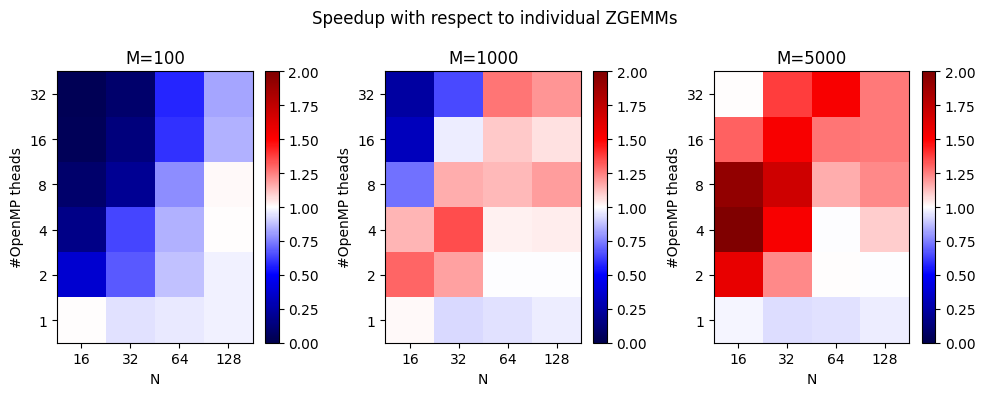

In [5]:
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,1+i)
    tt = t2.reshape(len(Nomp), -1, 6)[:, i::3, -1]
    plt.pcolormesh(tt, cmap='seismic', vmin=0, vmax=2)
    plt.yticks(np.arange(6)+0.5, Nomp)
    plt.ylabel('#OpenMP theads')
    plt.xticks(np.arange(4)+0.5, N)
    plt.xlabel('N')
    plt.title(f'M={M[i]}')
    plt.colorbar()
plt.suptitle('Speedup with respect to individual ZGEMMs')
plt.tight_layout()
plt.show()

### OpenMP scaling plots

In [6]:
def plot_timings(N, M, t):
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(t[:,0], t[:,-1], 'o--', label='batched')
    plt.plot(t[:,0], t[:,-2], 'o--', label='multiple')
    plt.ylabel('runtime (s)')
    plt.xlabel('# OpenMP threads')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(t[:,0], t[0,-1]/t[:,-1], 'o--', label='batched')
    plt.plot(t[:,0], t[0,-2]/t[:,-2], 'o--', label='multiple')
    plt.legend()
    plt.ylabel('OpenMP speedup')
    plt.twinx()
    plt.plot(t[:,0], t[:,-2]/t[:,-1], 's:', color='C2')
    plt.ylabel('speedup batched vs loop', color='C2')
    plt.xlabel('# OpenMP threads')
    plt.suptitle(f'N= {N}, M={M}')
    plt.tight_layout()
    plt.show()

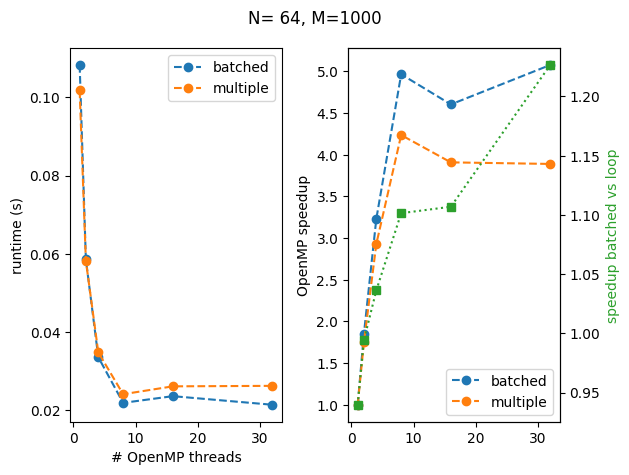

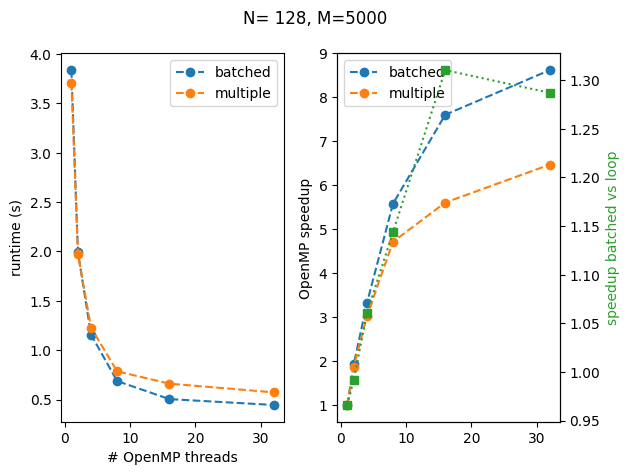

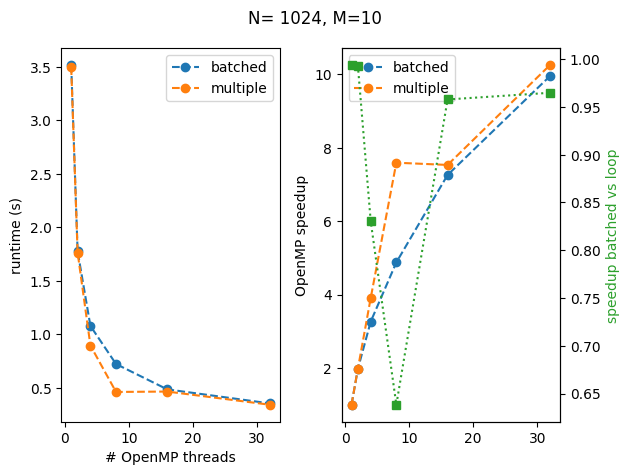

In [7]:
# some measurements for selected sizes for better scaling plots
N, M = 64, 1000
t = np.array([
    [1, 0.1017680019140244     ,   0.1082959994673729     ],
    [2, 5.8196999132633209E-002,   5.8534998446702957E-002],
    [4, 3.4738998860120773E-002,   3.3519998192787170E-002],
    [8, 2.4029999971389771E-002,   2.1817000582814217E-002],
    [16, 2.6045000180602074E-002,   2.3530000820755959E-002],
    [32, 2.6171000674366951E-002,   2.1337000653147697E-002],
])
plot_timings(N, M, t)


N, M = 128, 5000
t = np.array([
    [1, 3.705653905868530, 3.836133003234863],
    [2, 1.976717948913574, 1.992712974548340],
    [4, 1.227867960929871, 1.158033967018127],
    [8, 0.7860900163650513, 0.6873080134391785],
    [16, 0.6609209775924683, 0.5043879747390747],
    [32, 0.5726330280303955, 0.4449279904365540],
])
plot_timings(N, M, t)


N, M = 1024, 10
t = np.array([
    [1, 3.494848012924194, 3.516427993774414],
    [2, 1.763262033462524, 1.776129961013794],
    [4, 0.8942940235137939, 1.077283978462219],
    [8, 0.4603910148143768, 0.7213079929351807],
    [16, 0.4641039967536926, 0.4845609962940216],
    [32, 0.3408930003643036, 0.3533399999141693],
])
plot_timings(N, M, t) 

## GPU version

### read data

In [8]:
times_GPU = np.loadtxt('times_gpu.csv')
times_GPU = times_GPU.reshape(4, 3, -1)

N = times_GPU[:,0, 0]
M = times_GPU[0, :, 1]

### plot speedup

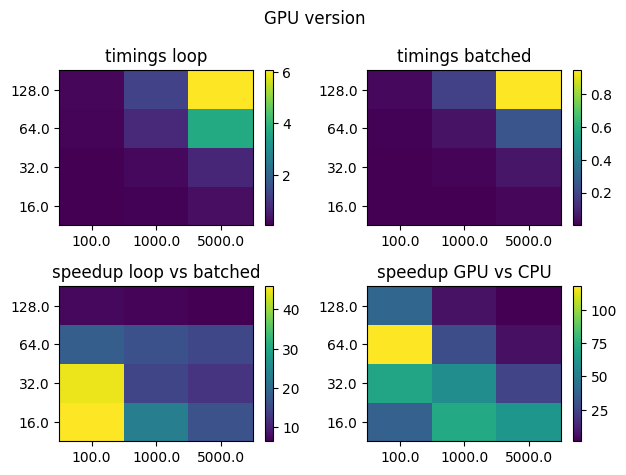

In [9]:
plt.figure()
plt.subplot(2,2,1)
plt.pcolormesh(times_GPU[:, :, -2])
plt.colorbar()
plt.title('timings loop')
plt.xticks(np.arange(3)+0.5, M)
plt.yticks(np.arange(4)+0.5, N)

plt.subplot(2,2,2)
plt.pcolormesh(times_GPU[:, :, -1])
plt.colorbar()
plt.title('timings batched')
plt.xticks(np.arange(3)+0.5, M)
plt.yticks(np.arange(4)+0.5, N)

plt.subplot(2,2,3)
plt.pcolormesh(times_GPU[:, :, -2]/times_GPU[:, :, -1])
plt.colorbar()
plt.title('speedup loop vs batched')
plt.xticks(np.arange(3)+0.5, M)
plt.yticks(np.arange(4)+0.5, N)

plt.subplot(2,2,4)
t_CPU = t2.copy().reshape(len(Nomp), -1, 6)[-1, :, :].reshape(4,3, -1)
plt.pcolormesh(t_CPU[:, :, -1]/times_GPU[:, :, -1])
plt.colorbar()
plt.title('speedup GPU vs CPU')
plt.xticks(np.arange(3)+0.5, M)
plt.yticks(np.arange(4)+0.5, N)

plt.suptitle('GPU version')
plt.tight_layout()

plt.show()